# ===============================
# 📌 1. Imports & Setup
# ===============================

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Config
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# ===============================
# 📥 2. Chargement des données
# ===============================

In [51]:
df = pd.read_csv("../Source/billets.csv", sep=";", encoding="utf-8")
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB
None


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


# ===============================
# 📊 3. Analyse exploratoire (EDA)
# ===============================

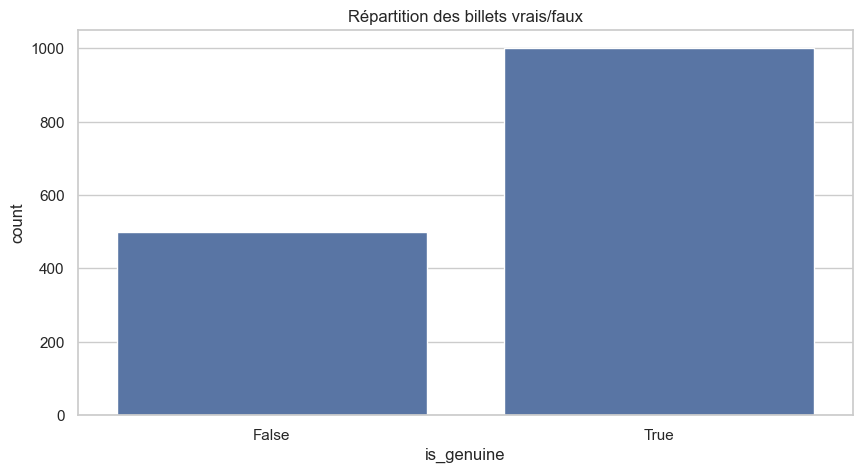

In [52]:
# Distribution vrai/faux
sns.countplot(x='is_genuine', data=df)
plt.title("Répartition des billets vrais/faux")
plt.show()

In [53]:
# Statistiques globales
display(df.describe())

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [54]:
# Vérification valeurs manquantes
print(df.isnull().sum())

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


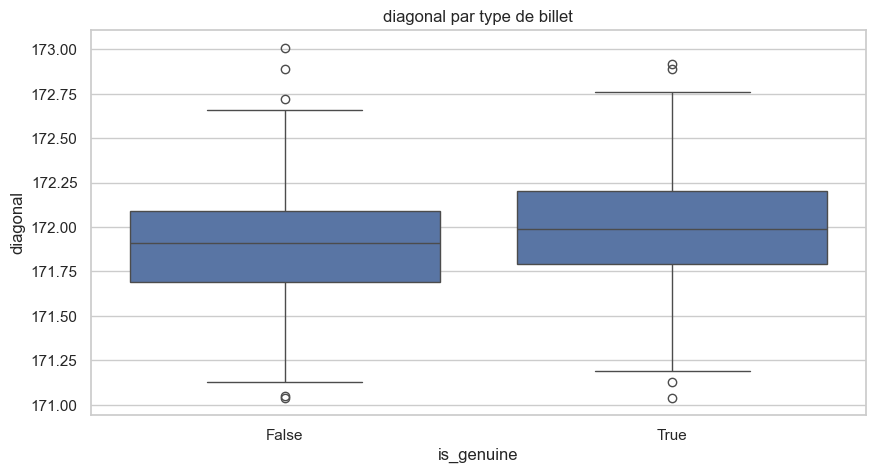

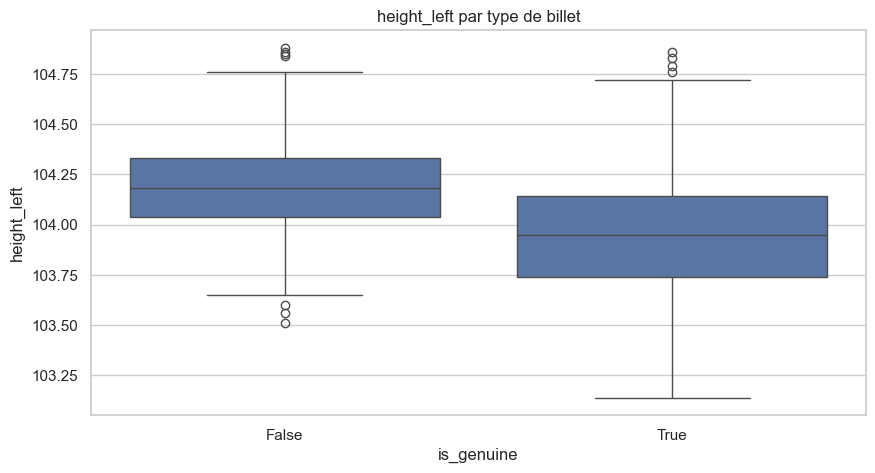

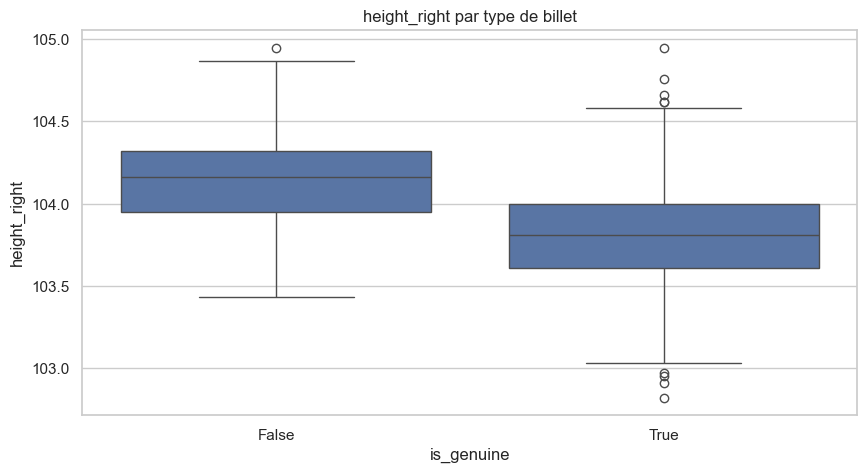

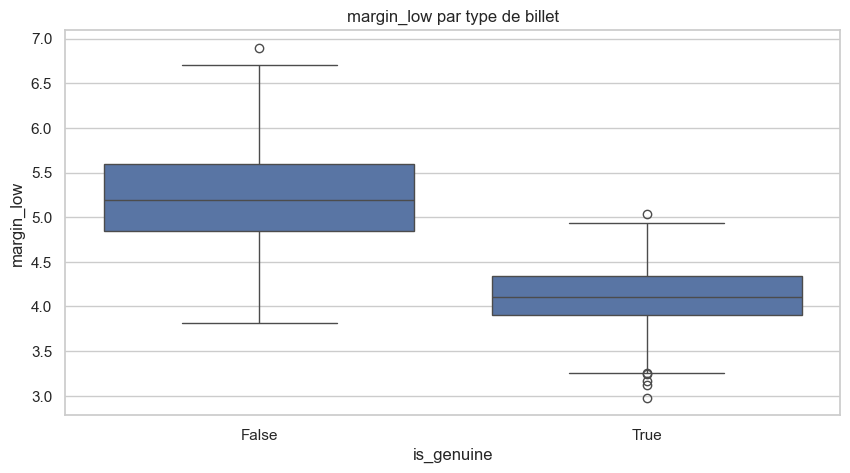

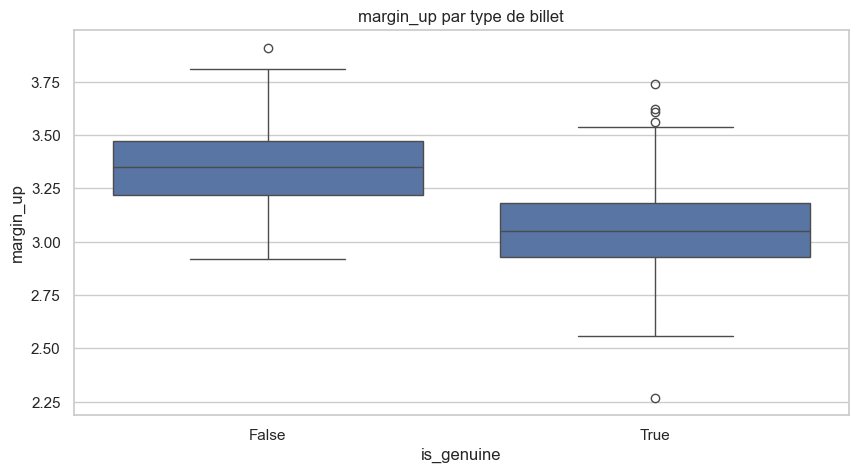

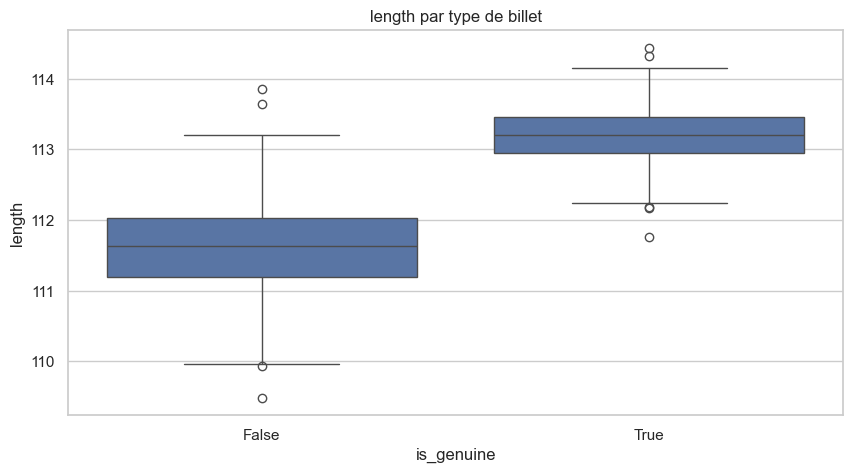

In [55]:
# Boxplots par variable
for col in df.columns[1:]:
    sns.boxplot(x='is_genuine', y=col, data=df)
    plt.title(f"{col} par type de billet")
    plt.show()


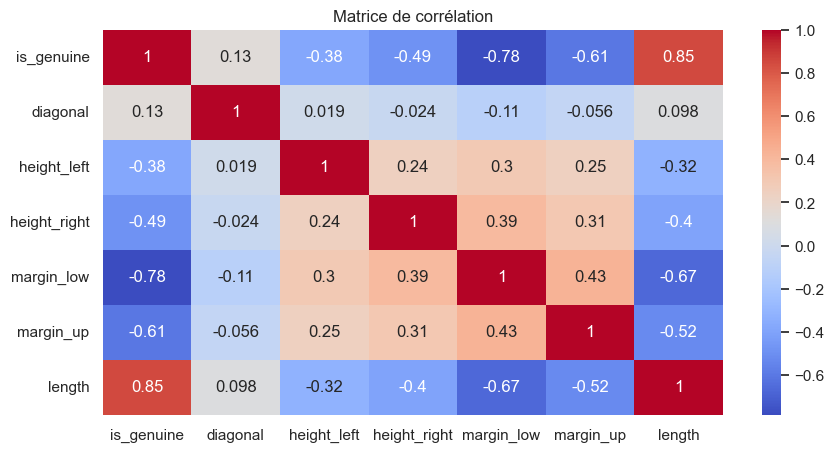

In [56]:

# Corrélation entre variables
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

# ===============================
# 🧹 4. Préparation des données
# ===============================

In [57]:
# Gestion des valeurs manquantes
df["margin_low"] = df["margin_low"].fillna(df["margin_low"].median())


In [58]:

# Séparation X / y
X = df.drop(columns=["is_genuine"])
y = df["is_genuine"].astype(int)  # Conversion bool -> int


In [59]:

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [60]:

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# ===============================
# 🔁 5. Régression logistique
# ===============================

In [61]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print("🔍 Régression Logistique")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

🔍 Régression Logistique
[[ 98   2]
 [  1 199]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       100
           1       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



# ===============================
# 🔀 6. K-means
# ===============================

In [62]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)

# Attribution des clusters
df["cluster"] = kmeans.labels_

# Comparaison clusters vs vérité terrain
# On doit mapper les clusters à is_genuine
cross = pd.crosstab(df["is_genuine"], df["cluster"])
print("Table de correspondance cluster / is_genuine :")
display(cross)


Table de correspondance cluster / is_genuine :


cluster,0,1
is_genuine,,
False,13,487
True,990,10


In [63]:

# Choix du mapping : cluster_majoritaire = vrai billet
mapping = {kmeans.labels_[i]: df['is_genuine'].iloc[i] for i in range(10)}
pred_kmeans = [int(mapping[label]) for label in kmeans.labels_]

print("🔍 K-means Clustering")
print(confusion_matrix(y, pred_kmeans))
print(classification_report(y, pred_kmeans))

🔍 K-means Clustering
[[   0  500]
 [   0 1000]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       500
           1       0.67      1.00      0.80      1000

    accuracy                           0.67      1500
   macro avg       0.33      0.50      0.40      1500
weighted avg       0.44      0.67      0.53      1500



/Users/ishemz/myprogramfiles/detection-faux-billet/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ishemz/myprogramfiles/detection-faux-billet/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ishemz/myprogramfiles/detection-faux-billet/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to

# ===============================
# 📈 7. Comparaison des performances
# ===============================

In [64]:
results = pd.DataFrame({
    "Méthode": ["Régression Logistique", "K-means"],
    "Accuracy": [accuracy_score(y_test, y_pred_lr), accuracy_score(y, pred_kmeans)]
})
display(results)

,Méthode,Accuracy
0,Régression Logistique,0.990000
1,K-means,0.666667


# ===============================
# 🧪 8. Utilisation sur données de production
# ===============================

In [65]:
df_prod = pd.read_csv("../Source/billets.csv", sep=";", encoding="utf-8")

# Nettoyage similaire
df_prod["margin_low"] = df_prod["margin_low"].fillna(df_prod["margin_low"].median())
X_prod = scaler.transform(df_prod)

# Prédiction
df_prod["pred_lr"] = lr.predict(X_prod)
df_prod["pred_kmeans"] = kmeans.predict(X_prod)
df_prod["pred_kmeans"] = df_prod["pred_kmeans"].map(mapping)

# Export éventuel
# df_prod.to_csv("resultats_predictions.csv", index=False)
display(df_prod.head())

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- is_genuine


In [ ]:
df_prod

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25
